In [1]:
import math
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def create_bar_plot(data, x_title, y_title):
    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111)
    ax.hist(x=data, bins='auto', alpha=0.7, rwidth=0.85)
    ax.grid(False)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    return fig

In [4]:
#Separating data for each drug/cell

def get_pos_map(obj_list, test_df, col):
    pos_map = {obj:[] for obj in obj_list}
    for i, row in test_df.iterrows():
        pos_map[row[col]].append(i)
    return pos_map

In [5]:
#Arrange the obj_list in the descending order of variance

def sort_var(obj_list, var_list):
    var_map = {}
    for i, obj in enumerate(obj_list):
        var_map[obj] = var_list[i]
    return {obj:var for obj,var in sorted(var_map.items(), key=lambda item:item[1], reverse=True)}

In [6]:
def calc_stddev(obj_list, train_df, col):
    var_list = [0.0] * len(obj_list)
    pos_map = get_pos_map(obj_list, train_df, col)
    for i, obj in enumerate(obj_list):
        train_vals = np.take(train_df['auc'], pos_map[obj])
        var_list[i] = np.std(train_vals)
    return sort_var(obj_list, var_list)

In [7]:
def filter_data(train_df, obj_list, col, threshold):
    
    stddev_map = calc_stddev(obj_list, train_df, col)
      
    filtered_list = []
    for k, obj in enumerate(stddev_map.keys()):
        if stddev_map[obj] < threshold:
            continue
        filtered_list.append(obj)

    if col == 'smiles':
        filtered_train_df = train_df.query("smiles in @filtered_list").reset_index()
    else:
        filtered_train_df = train_df.query("cell_line in @filtered_list").reset_index()
    return filtered_train_df

In [8]:
#Lenient random cell lines hold out cv

def create_strict_cv_data(train_df, cell_lines):
    
    cell_count = len(cell_lines)
    for k in range(1, 6):
        
        cv_size = int(cell_count/5) + k%2
        k_cell_lines = []
        print(len(cell_lines))

        for i in range(cv_size):
            r = rd.randint(0, len(cell_lines) - 1)
            k_cell_lines.append(cell_lines.pop(r))

        k_test_data = train_df.query('cell_line in @k_cell_lines')
        k_train_data = train_df.drop(k_test_data.index)

        k_test_data.to_csv("../data/" + str(k) + "_test_cg_strict.txt", sep="\t", header=False, index=False)
        k_train_data.to_csv("../data/" + str(k) + "_train_cg_strict.txt", sep="\t", header=False, index=False)

In [9]:
def create_top_100_loo_data(train_df, obj_list, col, obj_type):
    
    var_map = calc_var(obj_list, train_df, col)
    
    for k, obj in enumerate(var_map.keys()):
        if k == 100:
            break
        k_test_data = None
        k_train_data = None
        if col == 'smiles':
            k_test_data = train_df.query("smiles == @obj")
            k_train_data = train_df.query("smiles != @obj")
        else:
            k_test_data = train_df.query("cell_line == @obj")
            k_train_data = train_df.query("cell_line != @obj")
        
        k_test_data.to_csv("../data/" + str(k+1) + "_test_cg_" + obj_type + "_loo.txt", sep="\t", header=False, index=False)
        k_train_data.to_csv("../data/" + str(k+1) + "_train_cg_" + obj_type + "_loo.txt", sep="\t", header=False, index=False)

In [22]:
def create_per_drug_data(train_df, drug_name_map):
    drugs = set(train_df['smiles'])
    for drug in drugs:
        drug_name = drug_name_map[drug]
        drug_train_df = train_df.query("smiles == @drug")
        drug_train_df.to_csv("../data/training_files/train_gdsc2_" + drug_name + ".txt", sep="\t", header=False, index=False)

In [40]:
dataset = "gdsc2"

cell_lines = list(pd.read_csv("../data/cell2ind_" + dataset + ".txt", sep="\t", header=None, names=['I', 'C'])['C'])

drug_list = list(pd.read_csv("../data/drug2ind_" + dataset + "_all.txt", sep="\t", header=None, names=['I', 'D'])['D'])

all_df = pd.read_csv("../data/train_" + dataset + ".txt", sep="\t", header=None, names=['cell_line', 'smiles', 'auc'])

drug_info = pd.read_csv("../data/master_druglist_smiles_final.csv")[['name', 'isomeric_smiles']]
drug_name_map = dict(zip(drug_info.isomeric_smiles, drug_info.name))

#cell_line_info_df = pd.read_csv("../data/CCLE/sample_info.csv", sep=",")[["CCLE_Name", "primary_disease"]]

In [41]:
filtered_train_df = filter_data(all_df, drug_list, 'smiles', 0.15)

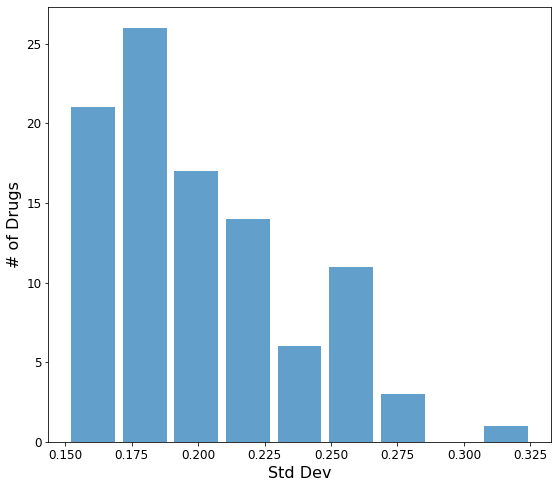

In [17]:
stddev_map = calc_stddev(drug_list, filtered_train_df, 'smiles')
gdsc2_drug_hist = create_bar_plot(stddev_map.values(), 'Std Dev', '# of Drugs')

In [42]:
filtered_drug_list = sorted(set(filtered_train_df['smiles']))

In [43]:
len(filtered_drug_list)

99

In [19]:
stddev_map['CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCNCC4)C5CCCC5)C(=O)C']

0.16464947924829318

In [44]:
create_per_drug_data(filtered_train_df, drug_name_map)

In [37]:
drug_df = pd.DataFrame(filtered_drug_list, columns=(['D']))
drug_df.to_csv("../data/drug2ind_gdsc2.txt", sep='\t', header=False, index=True)

In [46]:
drug_name_list = [v for k,v in drug_name_map.items() if k in filtered_drug_list]
drugname_df = pd.DataFrame(drug_name_list, columns=(['D']))
drugname_df.to_csv("../data/drugname_gdsc2.txt", sep='\t', header=False, index=False)

In [ ]:
filtered_train_df.to_csv("../data/" + dataset + "_filtered.txt", sep="\t", header=False, index=False)

In [ ]:
filtered_train_df = pd.read_csv("../data/" + dataset + "_filtered.txt", sep="\t", header=None, names=['cell_line', 'smiles', 'auc'])
cell_lines = list(pd.read_csv("../data/cell2ind_" + dataset + ".txt", sep="\t", header=None, names=['I', 'C'])['C'])
create_strict_cv_data(filtered_train_df, cell_lines)

In [ ]:
cell_line_info_df["primary_disease"] = cell_line_info_df["primary_disease"].apply(lambda s: str(s).lower())

In [ ]:
cell_line_info_df.groupby(["primary_disease"])["CCLE_Name"].count()

In [ ]:
for tissue in set(cell_line_info_df["primary_disease"]):
    cell_lines_x = list(cell_line_info_df.query('primary_disease == @tissue')["CCLE_Name"])
    train_data_x = train_data.query('cell_line in @cell_lines_x')
    print(tissue, len(train_data_x))

In [ ]:
tissue_1 = {"lung cancer"}

tissue_2 = {"kidney cancer", "bladder cancer", "leukemia", "myeloma", "neuroblastoma", "adrenal cancer", "prostate cancer"}

tissue_3 = {"gallbladder cancer", "colon/colorectal cancer", "liver cancer", 
            "esophageal cancer", "bile duct cancer", "pancreatic cancer", "gastric cancer"}

tissue_4 = {"breast cancer", "ovarian cancer", "endometrial/uterine cancer", "cervical cancer", "embryonal cancer", 
            "thyroid cancer", "bone cancer", "rhabdoid", "sarcoma", "fibroblast", "liposarcoma"}

tissue_5 = set(cell_line_info_df["primary_disease"]).difference(tissue_1)
tissue_5 = tissue_5.difference(tissue_2)
tissue_5 = tissue_5.difference(tissue_3)
tissue_5 = tissue_5.difference(tissue_4)

In [ ]:
#Strict tissue type cv

k = 5
tissue_k = tissue_5

cell_lines_k = list(cell_line_info_df.query('primary_disease in @tissue_k')["CCLE_Name"])
k_test_data = train_data.query('cell_line in @cell_lines_k')
k_train_data = train_data.drop(k_test_data.index)

print(len(k_test_data))
print(len(k_train_data))

k_test_data.to_csv("../data/" + str(k) + "_drugcell_test_cg_cell_tissue.txt", sep="\t", header=False, index=False)
k_train_data.to_csv("../data/" + str(k) + "_drugcell_train_cg_cell_tissue.txt", sep="\t", header=False, index=False)

In [ ]:
def divide_cell_list(cell_list):
    l = len(cell_list)
    size = int(l/5)
    cell_buckets = []
    for i in range(5):
        min = size * i
        max = size * (i+1)
        bucket_i = [cell_list[j] for j in range(min, max)]
        cell_buckets.append(bucket_i)
    for i in range(l%5):
        cell_buckets[i].append(cell_list[l - l%5 + i])
    return cell_buckets

In [ ]:
def create_cell_list_from_buckets(i):
    i = i - 1
    cell_list = []
    [cell_list.append(c) for c in cell_buckets_1[i]]
    [cell_list.append(c) for c in cell_buckets_2[i]]
    [cell_list.append(c) for c in cell_buckets_3[i]]
    [cell_list.append(c) for c in cell_buckets_4[i]]
    [cell_list.append(c) for c in cell_buckets_5[i]]
    return cell_list

In [ ]:
def create_train_test_files(cell_list, k):
    k_test_data = train_data.query('cell_line in @cell_list')
    k_train_data = train_data.drop(k_test_data.index)
    
    print(len(k_test_data))
    print(len(k_train_data))

    k_test_data.to_csv("../data/" + str(k) + "_drugcell_test_cg_cell_bucket.txt", sep="\t", header=False, index=False)
    k_train_data.to_csv("../data/" + str(k) + "_drugcell_train_cg_cell_bucket.txt", sep="\t", header=False, index=False)

In [ ]:
cell_lines_1 = list(cell_line_info_df.query('primary_disease in @tissue_1')["CCLE_Name"])
rd.shuffle(cell_lines_1)
cell_buckets_1 = divide_cell_list(cell_lines_1)

cell_lines_2 = list(cell_line_info_df.query('primary_disease in @tissue_2')["CCLE_Name"])
rd.shuffle(cell_lines_2)
cell_buckets_2 = divide_cell_list(cell_lines_2)

cell_lines_3 = list(cell_line_info_df.query('primary_disease in @tissue_3')["CCLE_Name"])
rd.shuffle(cell_lines_3)
cell_buckets_3 = divide_cell_list(cell_lines_3)

cell_lines_4 = list(cell_line_info_df.query('primary_disease in @tissue_4')["CCLE_Name"])
rd.shuffle(cell_lines_4)
cell_buckets_4 = divide_cell_list(cell_lines_4)

cell_lines_5 = list(cell_line_info_df.query('primary_disease in @tissue_5')["CCLE_Name"])
rd.shuffle(cell_lines_5)
cell_buckets_5 = divide_cell_list(cell_lines_5)

In [ ]:
cell_lines_1 = create_cell_list_from_buckets(1)
create_train_test_files(cell_lines_1, 1)

cell_lines_2 = create_cell_list_from_buckets(2)
create_train_test_files(cell_lines_2, 2)

cell_lines_3 = create_cell_list_from_buckets(3)
create_train_test_files(cell_lines_3, 3)

cell_lines_4 = create_cell_list_from_buckets(4)
create_train_test_files(cell_lines_4, 4)

cell_lines_5 = create_cell_list_from_buckets(5)
create_train_test_files(cell_lines_5, 5)

In [ ]:
#Lenient random drug hold out cv

drug_count = len(drug_list)

for k in range(1, 6):
    
    cv_size = int(drug_count/5) + k%2
    k_drugs = []
    print(len(drug_list))
        
    for i in range(cv_size):
        r = rd.randint(0, len(drug_list) - 1)
        k_drugs.append(drug_list.pop(r))
            
    k_test_data = train_data.query('smiles in @k_drugs')
    k_train_data = train_data.drop(k_test_data.index)
                
    k_test_data.to_csv("../data/" + str(k) + "_drugcell_test_cg_drug_random.txt", sep="\t", header=False, index=False)
    k_train_data.to_csv("../data/" + str(k) + "_drugcell_train_cg_drug_random.txt", sep="\t", header=False, index=False)

In [ ]:
create_top_100_loo_data(drug_list, 'smiles', 'drug')

In [ ]:
create_top_100_loo_data(cell_lines, 'cell_line', 'cell')